In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# cwd = os.getcwd()
# cwd

In [3]:
# raw_csv_data = pd.read_csv(cwd + '\TG.csv')
raw_csv_data = pd.read_csv('TG.csv')
df=raw_csv_data.copy()

In [4]:
para = 'Decreased'

In [5]:
df.Date.describe()

count           115
unique          115
top       15-Apr-20
freq              1
Name: Date, dtype: object

In [6]:
df

,Date,Confirmed,Recovered,Decreased
0,14-Mar-20,1,0,0
1,15-Mar-20,2,1,0
2,16-Mar-20,1,0,0
3,17-Mar-20,1,0,0
4,18-Mar-20,8,0,0
...,...,...,...,...
110,02-Jul-20,1213,987,8
111,03-Jul-20,1892,1126,8
112,04-Jul-20,1850,1342,5
113,05-Jul-20,1590,1166,7


In [7]:
df.Date = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,1,0,0
1,2020-03-15,2,1,0
2,2020-03-16,1,0,0
3,2020-03-17,1,0,0
4,2020-03-18,8,0,0


In [9]:
df

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,1,0,0
1,2020-03-15,2,1,0
2,2020-03-16,1,0,0
3,2020-03-17,1,0,0
4,2020-03-18,8,0,0
...,...,...,...,...
110,2020-07-02,1213,987,8
111,2020-07-03,1892,1126,8
112,2020-07-04,1850,1342,5
113,2020-07-05,1590,1166,7


In [10]:
df.set_index('Date', inplace=True)
df.index.freq = 'D'

In [11]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,1,0,0
2020-03-15,2,1,0
2020-03-16,1,0,0
2020-03-17,1,0,0
2020-03-18,8,0,0
...,...,...,...
2020-07-02,1213,987,8
2020-07-03,1892,1126,8
2020-07-04,1850,1342,5


In [12]:
# df.Date.describe()

In [13]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,1,0,0
2020-03-15,2,1,0
2020-03-16,1,0,0
2020-03-17,1,0,0
2020-03-18,8,0,0
...,...,...,...
2020-07-02,1213,987,8
2020-07-03,1892,1126,8
2020-07-04,1850,1342,5


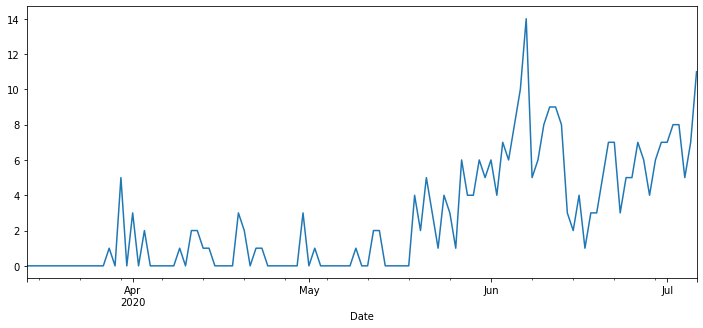

In [14]:
df[para].plot(figsize=(12,5));

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(df[para])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.594480
p-value                   0.872225
# lags used               5.000000
# observations          109.000000
critical value (1%)      -3.491818
critical value (5%)      -2.888444
critical value (10%)     -2.581120
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


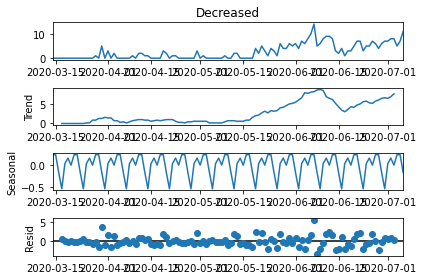

In [17]:
result = seasonal_decompose(df[para])
result.plot();

In [18]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df[para],k_diff=2)

In [19]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.068356e+00
p-value                 5.011848e-10
# lags used             9.000000e+00
# observations          1.030000e+02
critical value (1%)    -3.495493e+00
critical value (5%)    -2.890037e+00
critical value (10%)   -2.581971e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [20]:
# stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
#                           max_p=4, max_q=4,
#                           seasonal=False,
#                           d=None, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
                          max_p=4, max_q=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,           # set to stepwise
                         frequency=3)

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=486.039, BIC=491.512, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=467.955, BIC=476.163, Time=0.035 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=458.375, BIC=466.584, Time=0.026 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=484.303, BIC=487.039, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=459.662, BIC=470.607, Time=0.047 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=459.789, BIC=470.734, Time=0.045 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=458.920, BIC=472.601, Time=0.250 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.430 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -226.188
Date:                Tue, 14 Jul 2020   AIC                            458.375
Time:                        05:03:28   BIC                            466.584
Sample:                             0   HQIC                           461.707
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0756      0.067      1.125      0.261      -0.056       0.207
ma.L1         -0.6059      0.046    -13.144      0.000      -0.696      -0.516
sigma2         3.0843      0.289     10.671      0.000       2.518       3.651
===================================================================================
Ljung-Box (Q):                       34.27   Jarque-Bera (JB):                19.36
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               3.84   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
train = df.iloc[:90]
test = df.iloc[90:]

In [22]:
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# model = ARIMA(train[para],order=(2,2,1))
model = SARIMAX(train[para],order=(2,2,1),seasonal_order=(2,2,1,3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         Decreased   No. Observations:                   90
Model:             SARIMAX(2, 2, 1)x(2, 2, 1, 3)   Log Likelihood                -181.646
Date:                           Tue, 14 Jul 2020   AIC                            377.292
Time:                                   05:03:29   BIC                            394.139
Sample:                               03-14-2020   HQIC                           384.056
                                    - 06-11-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6860      0.139     -4.921      0.000      -0.959      -0.413
ar.L2         -0.4020      0.204     -1.969      0.049      -0.802      -0.002
ma.L1         -0.9994     12.994     -0.077      0.939     -26.466      24.468
ar.S.L3       -0.9780      0.143     -6.857      0.000      -1.258      -0.698
ar.S.L6       -0.4261      0.153     -2.792      0.005      -0.725      -0.127
ma.S.L3       -0.9994     17.324     -0.058      0.954     -34.953      32.954
sigma2         3.4765     55.107      0.063      0.950    -104.532     111.485
===================================================================================
Ljung-Box (Q):                       24.45   Jarque-Bera (JB):                 3.60
Prob(Q):                              0.97   Prob(JB):                         0.17
Heteroskedasticity (H):               2.29   Skew:                            -0.25
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(2,2,1,3) Predictions')

# df['forecast'] = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')

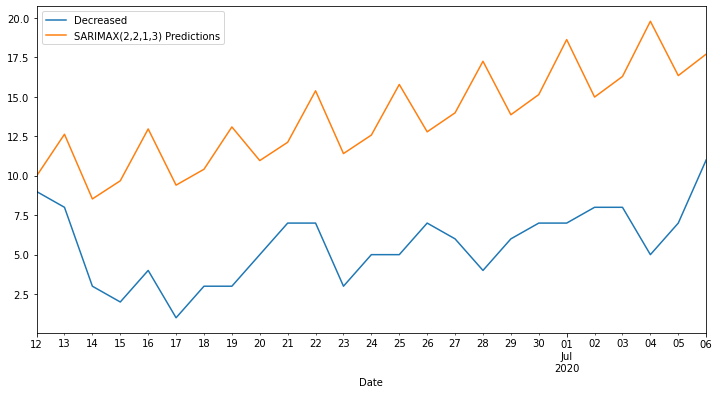

In [25]:
# Obtain predicted values
ax = test[para].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
# df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [26]:
# # from statsmodels.tools.eval_measures import rmse
# from statsmodels.tools.eval_measures import mse

# error = mse(test[para], predictions)
# # print(f'ARIMA(2,2,1) RMSE Error: {error:11.10}')
# # print(f'ARIMA(2,2,1) MSE Error: {error:11.10}')
# print(f'SARIMAX(2,2,1,3) MSE Error: {error:11.10}')

In [27]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test[para], predictions)
MAE

8.0274915722229

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# per_MAPE = (MAPE/sum(test[para]))*100
per_MAPE = mean_absolute_percentage_error(test[para], predictions)
print(per_MAPE,'%')

5.693256434200638 %


In [29]:
type(predictions)

pandas.core.series.Series

In [30]:
df['forecast'] = predictions
df

,Confirmed,Recovered,Decreased,d1,forecast
Date,,,,,
2020-03-14,1,0,0,NaN,NaN
2020-03-15,2,1,0,NaN,NaN
2020-03-16,1,0,0,0.0,NaN
2020-03-17,1,0,0,0.0,NaN
2020-03-18,8,0,0,0.0,NaN
...,...,...,...,...,...
2020-07-02,1213,987,8,1.0,14.985470
2020-07-03,1892,1126,8,-1.0,16.289174
2020-07-04,1850,1342,5,-3.0,19.787801


In [31]:
dictt = {f'{para}':test[para],f'Predicted_{para}':predictions}
dictt

{'Decreased': Date
 2020-06-12     9
 2020-06-13     8
 2020-06-14     3
 2020-06-15     2
 2020-06-16     4
 2020-06-17     1
 2020-06-18     3
 2020-06-19     3
 2020-06-20     5
 2020-06-21     7
 2020-06-22     7
 2020-06-23     3
 2020-06-24     5
 2020-06-25     5
 2020-06-26     7
 2020-06-27     6
 2020-06-28     4
 2020-06-29     6
 2020-06-30     7
 2020-07-01     7
 2020-07-02     8
 2020-07-03     8
 2020-07-04     5
 2020-07-05     7
 2020-07-06    11
 Freq: D, Name: Decreased, dtype: int64,
 'Predicted_Decreased': 2020-06-12     9.982729
 2020-06-13    12.628342
 2020-06-14     8.529909
 2020-06-15     9.678984
 2020-06-16    12.964852
 2020-06-17     9.404272
 2020-06-18    10.410450
 2020-06-19    13.092511
 2020-06-20    10.960464
 2020-06-21    12.120110
 2020-06-22    15.382458
 2020-06-23    11.404033
 2020-06-24    12.577385
 2020-06-25    15.783045
 2020-06-26    12.783066
 2020-06-27    13.985810
 2020-06-28    17.251709
 2020-06-29    13.864352
 2020-06-30    15

In [32]:
predicted_df = pd.DataFrame(dictt)
predicted_df

,Decreased,Predicted_Decreased
Date,,
2020-06-12,9,9.982729
2020-06-13,8,12.628342
2020-06-14,3,8.529909
2020-06-15,2,9.678984
2020-06-16,4,12.964852
2020-06-17,1,9.404272
2020-06-18,3,10.410450
2020-06-19,3,13.092511
2020-06-20,5,10.960464


In [33]:
# predicted_csv = predicted_df.to_csv('Predicted_TG.csv')
predicted_csv = pd.read_csv('Predicted_TG.csv')

predicted_csv.Date = pd.to_datetime(predicted_csv.Date)
predicted_csv.set_index('Date', inplace=True)
predicted_csv.index.freq = 'D'
# print(predicted_csv)
# predicted_csv = pd.concat([predicted_csv,predicted_df],axis=1,ignore_index=True)
predicted_csv = pd.merge(predicted_csv, predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(predicted_csv)
predicted_csv.to_csv('Predicted_TG.csv')

            Confirmed  Predicted_Confirmed  Recovered  Predicted_Recovered  \
Date                                                                         
2020-06-12        164           252.328205        285           137.356227   
2020-06-13        253           243.721551         74           123.890774   
2020-06-14        237           228.995013         25           142.170374   
2020-06-15        219           304.357924        389           150.870060   
2020-06-16        213           288.469855        261           171.269018   
2020-06-17        269           269.413666         44           220.534776   
2020-06-18        352           343.978271        230           203.312805   
2020-06-19        499           343.986249         51           232.567861   
2020-06-20        546           343.065580        154           293.846940   
2020-06-21        730           413.157017        225           283.804089   
2020-06-22        872           405.486573        274           

In [34]:
from pandas.tseries.offsets import DateOffset
import datetime
future_dates=[datetime.datetime(2020, 7, 7)+ DateOffset(n=x)for x in range(0,25)]

In [35]:
future_datest_df=pd.DataFrame(index=future_dates,columns=df.columns)

In [36]:
future_datest_df.tail()

,Confirmed,Recovered,Decreased,d1,forecast
2020-07-27,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN


In [37]:
future_df=pd.concat([df,future_datest_df])
future_df = future_df.drop("d1", axis=1)
future_df

,Confirmed,Recovered,Decreased,forecast
2020-03-14,1,0,0,NaN
2020-03-15,2,1,0,NaN
2020-03-16,1,0,0,NaN
2020-03-17,1,0,0,NaN
2020-03-18,8,0,0,NaN
...,...,...,...,...
2020-07-27,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN


In [38]:
future_df[[para, 'forecast']]

,Decreased,forecast
2020-03-14,0,NaN
2020-03-15,0,NaN
2020-03-16,0,NaN
2020-03-17,0,NaN
2020-03-18,0,NaN
...,...,...
2020-07-27,NaN,NaN
2020-07-28,NaN,NaN
2020-07-29,NaN,NaN
2020-07-30,NaN,NaN


In [39]:
# future_df['forecast'] = results.predict(start = 115, end = 139, dynamic= True)
future_pred = results.predict(start=115, end=139, dynamic=False, typ='levels')

In [40]:
future_df['forecast'] = future_pred

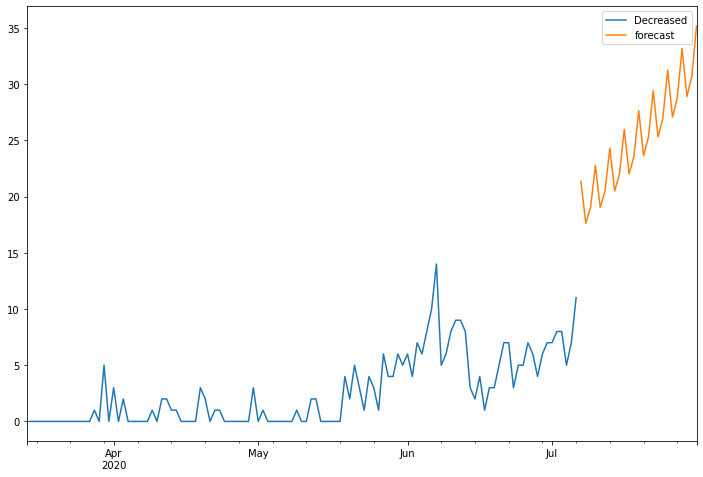

In [41]:
future_df[[para, 'forecast']].plot(figsize=(12, 8))

In [42]:
dicttt = {f'Future_Predicted_{para}':future_pred}
dicttt

{'Future_Predicted_Decreased': 2020-07-07    21.351463
 2020-07-08    17.609752
 2020-07-09    19.018346
 2020-07-10    22.769909
 2020-07-11    19.024508
 2020-07-12    20.477188
 2020-07-13    24.320060
 2020-07-14    20.495266
 2020-07-15    22.000995
 2020-07-16    25.968186
 2020-07-17    22.013294
 2020-07-18    23.566529
 2020-07-19    27.633074
 2020-07-20    23.631189
 2020-07-21    25.234793
 2020-07-22    29.412304
 2020-07-23    25.305013
 2020-07-24    26.959809
 2020-07-25    31.248827
 2020-07-26    27.059112
 2020-07-27    28.764336
 2020-07-28    33.160645
 2020-07-29    28.892178
 2020-07-30    30.649487
 2020-07-31    35.158240
 Freq: D, dtype: float64}

In [43]:
future_predicted_df = pd.DataFrame(dicttt)
future_predicted_df

,Future_Predicted_Decreased
2020-07-07,21.351463
2020-07-08,17.609752
2020-07-09,19.018346
2020-07-10,22.769909
2020-07-11,19.024508
2020-07-12,20.477188
2020-07-13,24.320060
2020-07-14,20.495266
2020-07-15,22.000995
2020-07-16,25.968186


In [44]:
# future_predicted_csv = future_predicted_df.to_csv('Future_Predicted_TG.csv')
# future_predicted_df.index.freq = 'D'
# future_predicted_csv = future_predicted_df.to_csv('Future_Predicted_TG.csv')

future_predicted_csv = pd.read_csv('Future_Predicted_TG.csv')

future_predicted_csv.Date = pd.to_datetime(future_predicted_csv.Date)
future_predicted_csv.set_index('Date', inplace=True)
future_predicted_csv.index.freq = 'D'
# print(future_predicted_csv)
# future_predicted_csv = pd.concat([future_predicted_csv,future_predicted_df],axis=1,ignore_index=True)
future_predicted_csv = pd.merge(future_predicted_csv, future_predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(future_predicted_csv)
future_predicted_csv.to_csv('Future_Predicted_TG.csv')

            Future_Predicted_Confirmed  Future_Predicted_Recovered  \
Date                                                                 
2020-07-07                  793.184355                  728.001367   
2020-07-08                  791.242405                  799.520432   
2020-07-09                  888.997171                  800.312366   
2020-07-10                  890.028814                  837.737152   
2020-07-11                  888.849483                  913.902799   
2020-07-12                  990.963503                  915.844167   
2020-07-13                  993.760968                  956.182022   
2020-07-14                  994.525206                 1036.352539   
2020-07-15                 1100.456032                 1040.450590   
2020-07-16                 1104.741279                 1083.337882   
2020-07-17                 1107.010277                 1167.080847   
2020-07-18                 1217.251932                 1173.318291   
2020-07-19          